## Init

In [7]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path+'/src')
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Users\dawson\Documents\GitHub\new-peak-project\src


In [8]:
from dotenv import dotenv_values
config = dotenv_values(".env")
print(config["DATA_PATH"])

C:\Users\dawson\Documents\Google Drive\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments


In [9]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *

# import scikit-learn
from sklearn.linear_model import LinearRegression
# tree models and support vector machines
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# import pearson correlation
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from copy import deepcopy

## Notebook Parameters

In [23]:
import os 
import numpy as np

### parameters 

notebook_name = 'exp15_feature_predictivity_nosub' # name of the notebook
distortion_scales = [1.05, 1.1, 1.2, 1.3, 1.5, 2, 4] # scales for the distortion of the model parameters
distortion_ranges = []
for scale in distortion_scales:
    min_scale = 1 / scale
    max_scale = scale
    distortion_ranges.append((min_scale, max_scale))
    

## Generation of ground truth model 

model_name = 'v4_drug_model' # name of the model
o_random_seed = 5
# p_overall_seed = 46 # different seed for parameter generation
no_observable_species = 15
no_feedback_regulations = 12
specie_value_range = (1000, 5000)
# param_range = (0.8, 1.2)
param_multiplier_range = (0.99, 1.01)

## Simulation parameters 

simulation_time = 1000 
simulation_step = 100

## Feature data generation 

feature_generation_method = 'lhs'
feature_generation_extra_params = {'min': 0.1, 'max': 10}
feature_generation_size = 1000 
feature_generation_seed = 50 # if -1 then 'o_random_seed' is used
if feature_generation_seed == -1:
    feature_generation_seed = o_random_seed


'''
Options: 
- 'feedback_prune': removes feedback regulations from the model 
- 'random parameter': randomizes a x% of parameter values of the model
'''

''' 
Options: 
- 'last_time_point' : only the last time point of the phosphorylated species is used
- 'dynamic_feature': computes the characteristic 'ten' dynamic feature for each specie data 
'''

## General parameters
parallelise = True
save_figures = True 
experiment_id = notebook_name + '_' + str(o_random_seed) + '_' + str(no_observable_species) + '_' + str(no_feedback_regulations)
experiment_folder = config['DATA_PATH'] + '/' + experiment_id + '/'
if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)
    
print(experiment_folder)

C:\Users\dawson\Documents\Google Drive\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments/exp15_feature_predictivity_nosub_5_15_12/


## Compute

In [24]:
print('Experiment ID: ', experiment_id)
print('Experiment folder: ', experiment_folder)
print('Distortion Range (For Ground Truth Param Range): ', distortion_ranges)

Experiment ID:  exp15_feature_predictivity_nosub_5_15_12
Experiment folder:  C:\Users\dawson\Documents\Google Drive\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments/exp15_feature_predictivity_nosub_5_15_12/
Distortion Range (For Ground Truth Param Range):  [(0.9523809523809523, 1.05), (0.9090909090909091, 1.1), (0.8333333333333334, 1.2), (0.7692307692307692, 1.3), (0.6666666666666666, 1.5), (0.5, 2), (0.25, 4)]


In [25]:
### Virtual Cell Creation
# create a drug enabled model 
from models.Utils import *
from models.DrugModelSpecification import DrugModelSpecification, Drug
from models.Solver.RoadrunnerSolver import RoadrunnerSolver
from models.SyntheticGen import generate_feature_data_v2, generate_target_data_diff_build
from models.SyntheticGen import generate_model_timecourse_data_diff_build
from models.Utils import last_time_point_method, dynamic_features_method
from joblib import Parallel, delayed
import pickle

verbose = True 
output_data = []
for j, dis_range in tqdm(enumerate(distortion_ranges)):
    
    print(f'------ Starting loop {j} for {dis_range}')

    model_drug_spec = DrugModelSpecification()
    model_drug_spec.generate_specifications(o_random_seed, no_observable_species, no_feedback_regulations, verbose=0)
    drug_0 = Drug('D0', 500, 500)
    rng = np.random.default_rng(o_random_seed)
    # add random 'up' and 'down' regulations to the drug
    regulation_dir = []
    for i, s in enumerate(model_drug_spec.A_species):
        reg_type = str(rng.choice(['up', 'down']))
        regulation_dir.append(reg_type)
        drug_0.add_regulation(s, reg_type)
    model_drug_spec.add_drug(drug_0)
    # print(model_drug_spec)
    # print(f'Feedback: {model_drug_spec.get_feedback_regulations()}')


    p_random_seeds = []
    feature_size = 1000 
    rng = np.random.default_rng(o_random_seed)
    # generate `feature_size` random seeds for different parameter sets using numpy, ensure that the seeds are unique
    p_random_seeds = rng.choice(range(1000000), feature_size, replace=False).tolist()

    G0_d = model_drug_spec.generate_network('drug_model_524', 
                                            specie_value_range, 
                                            dis_range, 
                                            param_multiplier_range,  
                                            verbose=0,
                                            random_seed=p_random_seeds[0])
    base_parameters = G0_d.get_parameters()
    base_initial_conditions = G0_d.get_state_variables()

    if verbose: print(f'--- Completed Model Initialisation for {dis_range}')
    # print(G0_d.get_antimony_model())


    # generate parameter sets for each random seed
    parameter_sets = []
    for p in p_random_seeds: 
        model_build = model_drug_spec.generate_network(f'param_seed_{p}', 
                                                specie_value_range, dis_range, param_multiplier_range, random_seed=p, verbose=0)
        parameter_sets.append(model_build.get_parameters())
        
    # test simulation 



    solver = RoadrunnerSolver()
    solver.compile(G0_d.get_sbml_model())
    # result = solver.simulate(0, 1000, 100)



    feature_data = generate_feature_data_v2(model_drug_spec, base_initial_conditions, feature_generation_method, feature_generation_extra_params, 1000, feature_generation_seed)
    target_data, _ = generate_target_data_diff_build(model_drug_spec, solver, 
                                                    feature_data, parameter_sets, 
                                                    {'start': 0, 'end': 1000, 'points': 100}, 
                                                    n_cores=1, verbose=False)

    if verbose: print(f'--- Generated Target Data for {dis_range}')


    # Suboptimal Model Generation

    # randomise links and parameters by using a different random seed
    new_spec = DrugModelSpecification()
    new_spec.generate_specifications(o_random_seed, no_observable_species, no_feedback_regulations, verbose=0)
    new_spec.add_drug(drug_0)
    new_model = new_spec.generate_network('submodel', specie_value_range, dis_range, param_multiplier_range, random_seed=100005352, verbose=0)
    new_base_parameters = new_model.get_parameters()
    new_base_initial_conditions = new_model.get_state_variables()
    new_solver = RoadrunnerSolver()
    new_solver.compile(new_model.get_sbml_model())

    # Minor distortion of the parameters to create a new set of parameters

    rng = np.random.default_rng(o_random_seed)
    modified_parameter_sets = []
    for params in parameter_sets:
        new_params = {}
        for key, value in params.items(): 
            new_params[key] = value * rng.uniform(0.1, 10) # distortion range, expectation is that the larger the worse the model performance 
        modified_parameter_sets.append(new_params)
        
        


    new_base_parameters_set = []
    for p in p_random_seeds: 
        new_base_parameters_set.append(new_base_parameters)

    # generate the timecourse data for the new model
    time_course_data = generate_model_timecourse_data_diff_build(model_drug_spec, 
                                                    solver, 
                                                    feature_data, 
                                                    parameter_sets,
                                                    {'start': 0, 'end': 1000, 'points': 100}, 
                                                    capture_species='all', n_cores=1, verbose=False)


    if verbose: print(f'--- Generated Timecourse Data for {dis_range}, Now running for Machine Learning Phase')


    all_species = model_drug_spec.A_species + model_drug_spec.B_species + model_drug_spec.C_species
    all_phos_species = [s+'p' for s in all_species]
    # apply the data engineering method to the feature data
    last_time_data = last_time_point_method(time_course_data, all_phos_species)

    dynamic_data = dynamic_features_method(time_course_data, all_phos_species, n_cores=8)
    combined_lp_data = pd.concat([feature_data, last_time_data], axis=1)
    combined_dyn_data = pd.concat([feature_data, dynamic_data], axis=1)
    feature_data_list = [feature_data, last_time_data, dynamic_data, combined_lp_data, combined_dyn_data]
    feature_data_names = ['feature_data', 'last_time_data', 'dynamic_data', 'combined_lp_data', 'combined_dyn_data']


    def evaluate_model(model, model_name, feature_data, feature_data_name, target_data, test_size=0.2, random_state=4):
        X_train, X_test, y_train, y_test = train_test_split(feature_data, target_data, test_size=test_size, random_state=random_state)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        # return a dictionary of the model performance
        return {'Model': model_name, 
                'Feature Data': feature_data_name,
                'Mean Squared Error': mean_squared_error(y_test, y_pred),
                'R2 Score': r2_score(y_test, y_pred),
                'Pearson Correlation': pearsonr(y_test, y_pred)[0],
                'Pearson P-Value': pearsonr(y_test, y_pred)[1]
                }
        
    # create a linear regression model
    lm = LinearRegression()
    # create a random forest model
    rf = RandomForestRegressor(n_estimators=100, random_state=o_random_seed)
    # create a gradient boosting model
    gb = GradientBoostingRegressor(n_estimators=100, random_state=o_random_seed)
    # create a support vector machine model
    svr = SVR(max_iter=10000)
    scaled_svr = Pipeline([('scaler', StandardScaler()), ('svr', svr)])
    # create a neural network model (simple)
    nn = MLPRegressor(hidden_layer_sizes=(20,), max_iter=10000, random_state=o_random_seed)
    scaled_nn = Pipeline([('scaler', StandardScaler()), ('nn', nn)])

    all_models = [lm, rf, gb, scaled_svr, scaled_nn]
    all_models_desc = ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'Support Vector Machine', 'Neural Network']
    zipped_model_data = list(zip(all_models, all_models_desc))
    all_features = feature_data_list
    all_features_desc = feature_data_names
    zipped_feature_data = list(zip(all_features, all_features_desc))

    # random states are rand ints between 0 and 10000, for n values 
    np.random.seed(o_random_seed)
    n_random = 10
    all_random_states = np.random.randint(0, 10000, n_random)

    parallelise = True 
    from tqdm import tqdm
    # tqdm is a progress bar library, use it to show the progress of the model evaluation
    metric_data = []
    if not parallelise:          
        for (feature_data, feature_data_name) in tqdm(zipped_feature_data):
            # print('Feature Data:', feature_data_name)
            # print('Feature Data Shape:', feature_data.shape)
            for (model, model_name) in zipped_model_data:
                # print('Model:', model_name)
                for rand in all_random_states:
                    metrics = evaluate_model(model, model_name, feature_data, feature_data_name, target_data['Cp'], random_state=rand)
                    metric_data.append(metrics)
                    
    else:        
        # parallelise the model evaluation process using joblib
        
        metric_data = Parallel(n_jobs=-1)(delayed(evaluate_model)(model, model_name, feature_data, feature_data_name, target_data['Cp'], random_state=rand) 
                                        for (feature_data, feature_data_name) in zipped_feature_data
                                        for (model, model_name) in zipped_model_data
                                        for rand in all_random_states)

    if verbose: print(f'--- Machine learning phase for {dis_range} complete, saving files and move on to {j+1}')
    
    # make a dataframe of the metric data
    metric_df = pd.DataFrame(metric_data)
    
    exp_group = str(distortion_scales[j])
    # create a new column for the distortion scale
    metric_df['Distortion Scale'] = exp_group
    output_data.append(metric_df)
    
    # save metric_df to a pickle file
    output_file = experiment_folder + f'metric_data_{exp_group}.pkl'
    metric_df.to_pickle(output_file)
    # print(f'Saved metric data to {output_file}')
    


0it [00:00, ?it/s]

------ Starting loop 0 for (0.9523809523809523, 1.05)
--- Completed Model Initialisation for (0.9523809523809523, 1.05)
--- Generated Target Data for (0.9523809523809523, 1.05)
--- Generated Timecourse Data for (0.9523809523809523, 1.05), Now running for Machine Learning Phase


1it [01:30, 90.97s/it]

--- Machine learning phase for (0.9523809523809523, 1.05) complete, saving files and move on to 1
------ Starting loop 1 for (0.9090909090909091, 1.1)
--- Completed Model Initialisation for (0.9090909090909091, 1.1)
--- Generated Target Data for (0.9090909090909091, 1.1)
--- Generated Timecourse Data for (0.9090909090909091, 1.1), Now running for Machine Learning Phase


2it [03:03, 91.61s/it]

--- Machine learning phase for (0.9090909090909091, 1.1) complete, saving files and move on to 2
------ Starting loop 2 for (0.8333333333333334, 1.2)
--- Completed Model Initialisation for (0.8333333333333334, 1.2)
--- Generated Target Data for (0.8333333333333334, 1.2)
--- Generated Timecourse Data for (0.8333333333333334, 1.2), Now running for Machine Learning Phase


3it [04:35, 91.95s/it]

--- Machine learning phase for (0.8333333333333334, 1.2) complete, saving files and move on to 3
------ Starting loop 3 for (0.7692307692307692, 1.3)
--- Completed Model Initialisation for (0.7692307692307692, 1.3)
--- Generated Target Data for (0.7692307692307692, 1.3)
--- Generated Timecourse Data for (0.7692307692307692, 1.3), Now running for Machine Learning Phase


4it [06:06, 91.62s/it]

--- Machine learning phase for (0.7692307692307692, 1.3) complete, saving files and move on to 4
------ Starting loop 4 for (0.6666666666666666, 1.5)
--- Completed Model Initialisation for (0.6666666666666666, 1.5)
--- Generated Target Data for (0.6666666666666666, 1.5)
--- Generated Timecourse Data for (0.6666666666666666, 1.5), Now running for Machine Learning Phase


5it [07:39, 92.02s/it]

--- Machine learning phase for (0.6666666666666666, 1.5) complete, saving files and move on to 5
------ Starting loop 5 for (0.5, 2)
--- Completed Model Initialisation for (0.5, 2)
--- Generated Target Data for (0.5, 2)
--- Generated Timecourse Data for (0.5, 2), Now running for Machine Learning Phase


6it [09:13, 92.68s/it]

--- Machine learning phase for (0.5, 2) complete, saving files and move on to 6
------ Starting loop 6 for (0.25, 4)
--- Completed Model Initialisation for (0.25, 4)
--- Generated Target Data for (0.25, 4)
--- Generated Timecourse Data for (0.25, 4), Now running for Machine Learning Phase


7it [10:48, 92.71s/it]

--- Machine learning phase for (0.25, 4) complete, saving files and move on to 7


In [26]:
output_df = pd.DataFrame()
all_loaded = True

for i, df in enumerate(output_data):
    # load the metric data for each scale
    exp_group = df.iloc[0]['Distortion Scale']  # get the distortion scale from the first row of the dataframe
    curr_scale = str(distortion_scales[i])
    
    if exp_group != curr_scale:
        print(f'Warning: Distortion scale mismatch! Expected {curr_scale}, but got {exp_group}.')
        all_loaded = False
        # if the file exists, load it
        if os.path.exists(experiment_folder + f'metric_data_{curr_scale}.pkl'):
            print(f'Loading metric data for scale {curr_scale} from file...')
            df = pd.read_pickle(experiment_folder + f'metric_data_{curr_scale}.pkl')
            all_loaded = True
        else:
            print(f'File not found for scale {curr_scale}, there is missing data for this scale.')
            all_loaded = False
            break 

    if not all_loaded:
        break
        
    output_df = pd.concat([output_df, df], ignore_index=True)

if not all_loaded:
    print('Not all data was loaded successfully, please check the files.')
else:
    print('All data loaded successfully. Producing final output dataframe.')
    # save the output_df to a pickle file
    output_file = experiment_folder + 'final_output_df.pkl'
    output_df.to_pickle(output_file)


All data loaded successfully. Producing final output dataframe.


## Analysis

In [27]:
import pandas as pd

# load the final output dataframe
seed_id, obs_id, fb_id = 5, 5, 2
load_folder = config['DATA_PATH'] + f'\\{notebook_name}_{seed_id}_{obs_id}_{fb_id}/'
output_df = pd.read_pickle(load_folder + 'final_output_df.pkl')



In [28]:
output_df

,Model,Feature Data,Mean Squared Error,R2 Score,Pearson Correlation,Pearson P-Value,Distortion Scale
0,Linear Regression,feature_data,0.005915,0.858674,0.926811,3.670434e-86,1.05
1,Linear Regression,feature_data,0.006541,0.862668,0.929418,1.154585e-87,1.05
2,Linear Regression,feature_data,0.006579,0.840803,0.918512,1.002929e-81,1.05
3,Linear Regression,feature_data,0.006082,0.858019,0.926854,3.474088e-86,1.05
4,Linear Regression,feature_data,0.005713,0.863247,0.930276,3.590742e-88,1.05
...,...,...,...,...,...,...,...
1745,Neural Network,combined_dyn_data,0.432973,0.917971,0.961657,3.346527e-113,4
1746,Neural Network,combined_dyn_data,0.369683,0.936538,0.971030,4.710562e-125,4
1747,Neural Network,combined_dyn_data,0.410628,0.920129,0.962414,4.820559e-114,4
1748,Neural Network,combined_dyn_data,0.441086,0.927148,0.963128,7.492777e-115,4


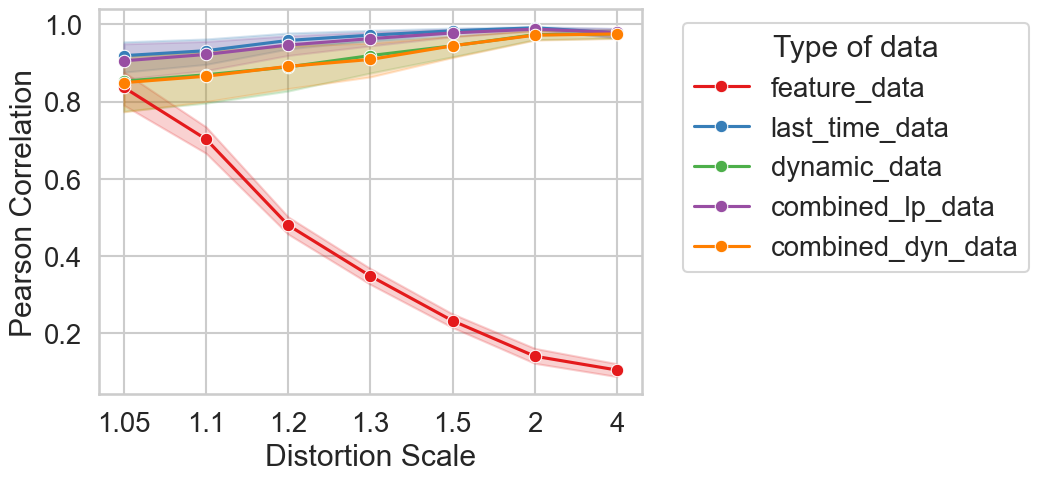

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
# set font to Arial
# plt.rcParams['font.family'] = 'Arial'
# set the figure size
plt.figure(figsize=(7, 5))
sns.set_style("whitegrid", {"font": "Arial"})
# set font size using seaborn via set_context
sns.set_context("talk", font_scale=1.2)
sns.lineplot(data=output_df, x='Distortion Scale', y='Pearson Correlation', hue='Feature Data', palette='Set1', marker='o')
# 90 degree rotation of the x-axis labels
# legend to the right
plt.legend(title='Type of data', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()